# Clustering NCAA Players

To begin the modeling portion of this exercise, we need to cluster NCAA players. We are using the data we scraped from barttorvik.com, which we have formatted for use and added features. Creating clusters will correspond to their roles within a team, and ideally help us "scout" through giving names to prospects' roles down the line.

In this process, we will use Expectation-maximalization with a Gaussian mixture model for roles, to create a well rounded picture (by using primary and secondary roles based on probabilities) for a player's place in a team. These primary and secondary combinations can be used to derive "hybrid" roles played by players as well.

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 150)

current = os.path.dirname(os.path.realpath("ncaa_clusters"))
parent = os.path.dirname(current)

ncaa = pd.read_csv(parent + "/player_data/ncaa_players.csv")
ncaa.head()

,ncaa_player_name,ncaa_team,ncaa_conf,ncaa_gp,ncaa_minutes_%,ncaa_ortg,ncaa_usg,ncaa_efg%,ncaa_ts%,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ftm,ncaa_fta,ncaa_ft%,ncaa_2pm,ncaa_2pa,ncaa_2p%,ncaa_3pm,ncaa_3pa,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_yr,ncaa_ht,ncaa_porpag,ncaa_adjoe,ncaa_foul_rate,ncaa_year,ncaa_recruit_rank,ncaa_ast_tov_ratio,ncaa_rim_makes,ncaa_rim_att,ncaa_mid_range_makes,ncaa_mid_range_att,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dunks_made,ncaa_dunks_att,ncaa_dunk_fg%,ncaa_draft_pick,ncaa_drtg,ncaa_adrtg,ncaa_dporpag,ncaa_stops,ncaa_bpm,ncaa_obpm,ncaa_dbpm,ncaa_gbpm,ncaa_min_per_game,ncaa_ogbpm,ncaa_dgbpm,ncaa_oreb,ncaa_dreb,ncaa_treb,ncaa_ast,ncaa_stl,ncaa_blk,ncaa_pts,ncaa_fga,ncaa_tov,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio
0,Pooh Williams,Utah St.,WAC,32,0.640,108.3,0.181,0.530,0.533,0.023,0.059,0.146,0.141,1.031250,1.937500,0.532,2.187500,4.187500,0.522,1.125000,3.125000,0.360,0.009,0.014,0.265,Jr,75,1.801170,104.8020,2.7,2010,0.0,1.999909,1.500000,2.343750,0.687500,1.843750,0.6400,0.3729,0.187500,0.218750,0.8571,0.0,100.8750,98.5761,2.63663,124.8270,2.282520,2.42698,-0.144461,1.062230,27.3125,0.785960,0.276271,0.4688,1.3750,1.8438,2.1875,0.5938,0.2188,8.7812,7.312500,1.0938,0.948417,0.320513,0.252137,0.427350,0.299145
1,Dana Smith,Longwood,ind,27,0.818,99.8,0.277,0.499,0.538,0.069,0.176,0.156,0.186,4.555556,6.925926,0.658,4.666667,9.666667,0.483,1.222222,3.370370,0.363,0.014,0.014,0.531,Sr,77,2.553470,108.2240,4.3,2010,0.0,0.773810,3.037037,4.962963,1.629630,4.703704,0.6119,0.3465,0.111111,0.148148,0.7500,0.0,106.3010,110.6310,1.80142,168.4280,-0.441037,1.10734,-1.548380,-0.118050,32.7037,1.949350,-2.067400,2.1481,4.9259,7.0741,2.4074,0.8148,0.4815,17.5556,13.037037,3.1111,0.914566,0.380682,0.360795,0.258523,0.184659
2,Carlos Strong,Boston University,AE,35,0.762,118.1,0.164,0.588,0.609,0.047,0.115,0.123,0.151,2.085714,3.057143,0.682,1.857143,3.885714,0.478,1.685714,3.571429,0.472,0.014,0.031,0.410,Sr,75,2.758120,111.8110,3.5,2010,3.2,1.340383,1.342857,2.228571,0.542857,1.657143,0.6026,0.3276,0.371429,0.428571,0.8667,0.0,95.9093,98.0859,3.00456,215.8570,6.077490,3.66533,2.412160,5.253060,30.6857,2.914710,2.338340,1.3429,3.2286,4.5714,1.8000,1.6571,0.4000,10.8571,7.457143,1.3429,1.070173,0.298851,0.222222,0.478927,0.241379
3,Eulis Stephens,Detroit,Horz,31,0.316,110.2,0.139,0.513,0.559,0.061,0.106,0.084,0.160,1.064516,1.580645,0.673,1.064516,1.741935,0.611,0.129032,0.709677,0.182,0.011,0.017,0.645,Sr,76,0.655344,99.7749,3.8,2010,0.0,1.124976,0.870968,1.290323,0.193548,0.451613,0.6750,0.4286,0.129032,0.161290,0.8000,0.0,99.3834,98.5807,1.30229,70.4798,0.667967,0.23597,0.431997,0.611289,13.5484,-0.283722,0.895011,0.6774,1.2258,1.9032,0.5806,0.3871,0.1290,3.5806,2.451613,0.5161,0.977452,0.526316,0.184211,0.289474,0.236824
4,Brett Gifford,Albany,AE,30,0.394,79.3,0.101,0.468,0.468,0.044,0.183,0.072,0.345,0.133333,0.300000,0.444,0.966667,2.033333,0.475,0.000000,0.033333,0.000,0.054,0.014,0.145,Sr,83,-1.121340,66.4800,5.0,2010,0.0,0.620668,0.533333,0.700000,0.433333,1.333333,0.7619,0.3250,0.000000,0.000000,0.0000,0.0,101.0190,104.1200,1.30440,100.5920,-2.658680,-4.68582,2.027140,-3.827150,16.9333,-5.133030,1.305880,0.6333,2.6667,3.3000,0.6000,0.4000,0.8333,2.0667,2.066667,0.9667,0.652910,0.338710,0.645161,0.016129,0.290323


## Feature Selection

Once we've loaded in the data and packages that we will intially be using, we need to review the data. We want the roles to reflect modern basketball, since the game has come a long way since the data was initially collected in 2010. Therefore, we'll use this season and the four before it to create the cluster model, before predicting the other data in the frame onto it.

Our next steps will be to drop the columns that we don't need to work with, including categorical features like conference or irrelevant attributes like draft pick. This will also include "team stats" such as offensive and defensive ratings, "out of date stats" such as bpm (not gbpm which corresponds to an updated bpm model), and counting stats like points, rebounds or attempts.

After this inital selection, we will examine the correlation matrix to then remove any highly correlated features.

In [2]:
ncaa_c = ncaa[ncaa.ncaa_year.between(np.max(ncaa.ncaa_year)-4, np.max(ncaa.ncaa_year))].reset_index(drop=True)
ncaa_c = ncaa_c.drop(["ncaa_player_name", "ncaa_team", "ncaa_conf", "ncaa_gp", 
                    "ncaa_minutes_%", "ncaa_ortg", "ncaa_ftm", "ncaa_fta", 
                    "ncaa_yr", "ncaa_ht", "ncaa_2pm", "ncaa_2pa", "ncaa_3pm",
                    "ncaa_3pa", "ncaa_porpag", "ncaa_adjoe", "ncaa_year", 
                    "ncaa_recruit_rank", "ncaa_rim_makes", "ncaa_rim_att",
                    "ncaa_mid_range_makes", "ncaa_mid_range_att", "ncaa_dunks_made",
                    "ncaa_dunks_att", "ncaa_draft_pick", "ncaa_drtg", "ncaa_adrtg", 
                    "ncaa_dporpag", "ncaa_stops", "ncaa_bpm", "ncaa_obpm", "ncaa_dbpm", 
                    "ncaa_min_per_game", "ncaa_oreb", "ncaa_dreb", "ncaa_treb", "ncaa_ast", 
                    "ncaa_stl", "ncaa_blk", "ncaa_pts", "ncaa_fga", "ncaa_tov", 
                    # "GMM_Primary_Cluster", "GMM_Secondary_Cluster"
                   ], axis=1)

ncaa_c.corr().style.background_gradient(cmap='coolwarm')

,ncaa_usg,ncaa_efg%,ncaa_ts%,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ft%,ncaa_2p%,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_foul_rate,ncaa_ast_tov_ratio,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dunk_fg%,ncaa_gbpm,ncaa_ogbpm,ncaa_dgbpm,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio
ncaa_usg,1.000000,-0.025248,0.064643,0.025152,0.192352,0.451372,-0.089245,0.196468,-0.004060,0.080768,-0.033019,0.188529,0.117053,-0.137073,-0.100809,0.000372,0.138010,0.122853,0.281049,0.429195,-0.103297,0.045332,0.030065,0.313792,-0.189340,-0.143743
ncaa_efg%,-0.025248,1.000000,0.950146,0.315928,0.247550,-0.198821,-0.188225,-0.026426,0.737385,0.093228,0.306901,-0.145571,0.114831,0.097977,-0.103956,0.574604,0.349848,0.225576,0.524919,0.547063,0.227119,0.826470,0.294484,-0.177138,-0.158444,-0.205677
ncaa_ts%,0.064643,0.950146,1.000000,0.252886,0.219297,-0.114225,-0.197980,0.200594,0.690160,0.153072,0.238441,-0.104732,0.221431,0.040498,-0.063721,0.534331,0.350539,0.200242,0.578627,0.622667,0.217963,0.862676,0.252420,-0.152518,-0.135305,-0.164158
ncaa_oreb%,0.025152,0.315928,0.252886,1.000000,0.645993,-0.405614,0.009317,-0.376182,0.449784,-0.468627,0.614852,-0.165058,0.427144,0.525251,-0.465778,0.347747,0.041938,0.419860,0.164267,0.086948,0.210098,0.204051,0.706900,0.136269,-0.673697,-0.338077
ncaa_dreb%,0.192352,0.247550,0.219297,0.645993,1.000000,-0.221334,-0.005094,-0.227064,0.367853,-0.269081,0.494171,-0.088629,0.295137,0.301662,-0.356004,0.311449,0.062319,0.397290,0.255216,0.173861,0.262440,0.169384,0.475133,0.136178,-0.476299,-0.267008
ncaa_ast%,0.451372,-0.198821,-0.114225,-0.405614,-0.221334,1.000000,0.224900,0.199821,-0.195783,0.201200,-0.336521,0.387060,-0.010587,-0.334260,0.624636,-0.194882,0.026096,-0.216306,0.174986,0.192903,0.058328,-0.253447,-0.144467,0.136821,0.051825,0.703617
ncaa_to%,-0.089245,-0.188225,-0.197980,0.009317,-0.005094,0.224900,1.000000,-0.230042,-0.078271,-0.178548,0.032461,0.105653,0.229595,0.302894,-0.217187,-0.121212,-0.108083,-0.047060,-0.428293,-0.563784,0.008456,-0.552333,0.260206,0.058405,-0.253840,0.461212
ncaa_ft%,0.196468,-0.026426,0.200594,-0.376182,-0.227064,0.199821,-0.230042,1.000000,-0.160954,0.356110,-0.315190,0.053050,-0.162624,-0.355230,0.221831,-0.116229,0.085750,-0.188170,0.217858,0.342234,-0.095813,0.234679,-0.426468,-0.018341,0.374104,0.017029
ncaa_2p%,-0.004060,0.737385,0.690160,0.449784,0.367853,-0.195783,-0.078271,-0.160954,1.000000,-0.196241,0.398434,-0.085269,0.239099,0.220070,-0.176991,0.771813,0.433060,0.362504,0.391062,0.343310,0.275225,0.577617,0.483693,-0.100776,-0.359731,-0.173424
ncaa_3p%,0.080768,0.093228,0.153072,-0.468627,-0.269081,0.201200,-0.178548,0.356110,-0.196241,1.000000,-0.380076,0.096544,-0.339448,-0.396142,0.278053,-0.133962,0.011810,-0.184434,0.195594,0.307579,-0.086549,0.182341,-0.524066,-0.177741,0.539605,0.100078


In examining the correlation matrix, the only egregious feature is the shooting effenciency measures. They are highly correlated with each other, and also with our engineered measure, points per possession. Therefore, we will remove both features. 

Also, regarding the gbpm features, gbpm is essentially a linear combination of the ogbpm and dgbpm. We will remove it accordingly. Also, we will remove ogbpm, as I'm not comfortable including an all-in-one metric for offense when we already have so many other features to dictate playstyle. 

Defense is system dependent and reactive, so the vague defensive measurement of dgbpm is unfortunately all we have to measure on-ball and off-ball team defense out of measured stats like steals and blocks so we opt to keep it.

The last "irrelevant features" to drop are 2p% (as it's explained by rim% and mid% in more detail) and dunk% (as it adds unnecessary complexity) and from my domain knowledge, likely tells the same stories that rebounding, block, and rim rates do.

Last, we need to standardize for later PCA.

In [3]:
ncaa_c = ncaa_c.drop(["ncaa_efg%", "ncaa_ts%", "ncaa_2p%",
                      "ncaa_dunk_fg%", "ncaa_gbpm", "ncaa_ogbpm",
                      # "GMM_Primary_Cluster", "GMM_Secondary_Cluster"
                     ], axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=False)
scaler.fit_transform(ncaa_c)
ncaa_c.head()

,ncaa_usg,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ft%,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_foul_rate,ncaa_ast_tov_ratio,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dgbpm,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio
0,0.662553,-0.435233,0.450373,1.431110,0.886987,0.188167,0.674627,0.238479,-1.124235,0.244099,0.008305,0.113310,0.516953,-0.030708,0.035081,0.084703,1.038951,-0.646860,-0.549373,0.717826
1,-0.810251,1.354992,0.163678,-0.988345,-0.887829,-0.776107,-2.074580,-0.591931,0.005236,1.720097,3.914712,-0.526243,1.274620,-1.149199,-0.146331,0.097503,0.812313,1.748302,-1.595884,-0.546663
2,-1.567694,-0.765736,-1.167408,-0.338548,-1.128168,0.880266,0.334594,-0.545797,-0.622248,0.377703,-0.367311,2.107388,-0.427922,0.656772,-0.525935,1.098726,0.160855,-1.433585,0.607083,0.587599
3,-0.052809,-0.738194,-0.450669,1.804397,1.423130,-0.161772,0.276716,-0.730332,0.507222,-0.233055,-0.818050,0.847241,-0.414677,-1.633641,-0.027956,-0.954499,0.212138,-0.617740,0.140998,1.552101
4,-1.252093,0.088064,0.757547,-0.338548,0.535722,-1.304903,0.508228,0.838220,0.005236,0.594013,-0.066818,-0.131247,0.195519,-1.447523,0.432235,-0.284016,0.804153,-0.190552,-0.507513,0.508850


## PCA Decomposition

Now, for PCA, we need to choose the number of components to retain to fully model the distribution in reduced dimensions.

In [4]:
from sklearn.decomposition import PCA

pca = PCA().fit(ncaa_c)

pca_g80 = np.where(np.round(np.cumsum(pca.explained_variance_ratio_), 2)>=.8)[0][0]
print(f"Number of Components: {pca_g80+1}")

Number of Components: 8


In [5]:
pca = PCA(n_components=8).fit(ncaa_c)
pca_c = pca.transform(ncaa_c)

## GMM Clustering

Now that we've dimensionaly reduced both subsets of data, we will begin work on the EM with a Gaussian Mixture Model for clustering the data. 

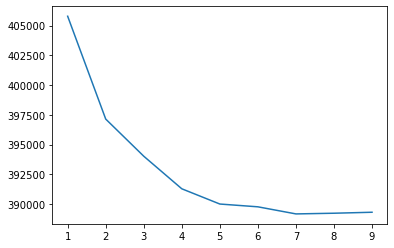

In [6]:
from sklearn.mixture import GaussianMixture

gauss_bic = []
gauss_comp = []
for i in np.arange(1, 10):
    gauss = GaussianMixture(n_components=i, covariance_type = "full", random_state=9)
    bic = gauss.fit(pca_c).bic(pca_c)
    gauss_bic += [bic]
    gauss_comp += [i]
    
plt.plot(gauss_comp, gauss_bic)
plt.xticks(gauss_comp);

The BIC stops decreasing at 7. This gives us more roles than the classic value of 5 positions, so it indicates there may be some further role diversity beyond that classic view.

Because our clustering technique will take a probabilistic perspective, this will allow us to identify the areas that players play in and we can see intersection.

In [7]:
gaussian = GaussianMixture(n_components=7, covariance_type="full",
                           n_init=5, random_state=9)
gaussian.fit(pca_c)

GaussianMixture(n_components=7, n_init=5, random_state=9)

In [8]:
gaussian.means_[0,:2]

array([-1.77093691, -1.05860421])

In [9]:
clusters = pd.DataFrame(np.round(gaussian.predict_proba(pca_c), 3), 
                        columns=["P(1)", "P(2)", "P(3)", "P(4)", "P(5)", "P(6)", "P(7)"])

In [10]:
arank = clusters.apply(np.argsort, axis=1)
brank = clusters.apply(np.sort, axis=1)

clusters["Primary Cluster"] = (arank.values[:, ::-1][:,:2][:,0]+1)
clusters["P(Primary Cluster)"] = brank.str[-1]
clusters["Secondary Cluster"] = (arank.values[:, ::-1][:,:2][:,1]+1)
clusters["P(Secondary Cluster)"] = brank.str[-2]

clusters.loc[clusters["P(Secondary Cluster)"] < .2, "Secondary Cluster"] = 0

In [11]:
clusters.head()

,P(1),P(2),P(3),P(4),P(5),P(6),P(7),Primary Cluster,P(Primary Cluster),Secondary Cluster,P(Secondary Cluster)
0,0.053,0.333,0.000,0.231,0.194,0.183,0.006,2,0.333,4,0.231
1,0.000,0.000,0.987,0.000,0.005,0.008,0.000,3,0.987,0,0.008
2,0.787,0.009,0.000,0.028,0.016,0.161,0.000,1,0.787,0,0.161
3,0.024,0.586,0.000,0.360,0.000,0.029,0.000,2,0.586,4,0.360
4,0.054,0.001,0.000,0.032,0.302,0.607,0.004,6,0.607,5,0.302


In [12]:
np.unique(clusters["Primary Cluster"], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([1314, 3646, 1701, 1313, 3482, 1170, 2715]))

In [13]:
ncaa_c = ncaa_c.assign(GMM_Primary_Cluster =  clusters["Primary Cluster"])

ncaa_c = ncaa_c.assign(GMM_Secondary_Cluster = clusters["Secondary Cluster"])

To name the clusters, we have to check the mean values of the clusters for players that do not have a secondary cluster. Then, we can evaluate what the clusters' roles are and when a player has a seconary cluster, what their secondary skillset is.

In [14]:
ncaa_c[ncaa_c.GMM_Secondary_Cluster==0].groupby("GMM_Primary_Cluster").mean()

,ncaa_usg,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ft%,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_foul_rate,ncaa_ast_tov_ratio,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dgbpm,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio,GMM_Secondary_Cluster
GMM_Primary_Cluster,,,,,,,,,,,,,,,,,,,,,
1,-1.144459,-0.660074,-0.726447,-0.438602,-0.481830,0.281418,0.463870,-0.508773,-0.343819,-0.768078,-0.348345,0.877752,-0.368509,-0.027621,-0.185142,0.427042,-0.965310,-1.140687,1.410105,0.028435,0.0
2,0.824530,-0.745746,-0.487966,1.266853,0.034553,0.577052,0.401547,-0.560478,0.550969,-0.115640,-0.615694,0.724198,-0.278934,0.118602,-0.022647,-0.136025,-0.426312,0.273168,0.222240,0.523823,0.0
3,-0.159101,1.603797,0.954014,-0.857769,0.057298,-0.879535,-2.007935,1.378141,-0.632105,0.945300,1.107074,-0.947909,0.538844,0.163311,0.252007,0.422111,1.484317,0.551012,-1.550891,-0.691596,0.0
4,-0.375619,-0.537061,-0.445910,1.177111,1.381465,-0.435216,-0.159791,-0.402187,1.033875,0.299220,0.043223,0.867086,-0.637891,-0.172108,0.390152,-1.297591,0.142105,0.226883,-0.241205,2.154247,0.0
5,0.436935,0.733961,0.761516,-0.389500,-0.230033,-0.101823,0.191598,0.407801,-0.224842,0.265646,0.196984,-0.562471,0.389552,0.149287,0.014431,0.235902,0.421983,0.386268,-0.559889,-0.536504,0.0
6,-0.905989,0.665764,0.336749,-0.522034,0.979719,-1.154257,-0.475316,0.795178,-0.211008,0.953587,1.166156,-0.343384,0.514427,-0.341043,0.460709,-0.246004,1.157948,-0.439274,-0.765315,0.269223,0.0
7,-0.196735,-0.556634,-0.419558,-0.588392,-0.767392,0.490119,0.502941,-0.431793,-0.445768,-0.815607,-0.556323,-0.228805,-0.201194,-0.096727,-0.563185,0.326555,-0.929207,-0.492297,1.048365,-0.630463,0.0


Inspecting the clusters, we can begin to understand what players' roles are within them. 

- 1) lowest usage, lowest reb numbers, great 3p% and ft%, lowest ftrate, most efficient scorer, low rim and mid proportion, very high 3pt proportion. 3 point focused
- 2) highest usage, low reb numbers, highest ast%, high ast2tov and ast2fg, good shooting numbers, fairly balanced shot profile. perimeter based
- 3) highest rebound numbers, lowest ast% and low ast2fg, worst 3p% and prop by far, high ftrate, rim prop and blk%
- 4) high playmaking numbers, highest ast2fg, balanced scoring profile, inefficient scorer, lower rebounding nnumbers, high steal numbers. pass first guard
- 5) high usage, high reb numbers, good shooting numbers, 
- 6) toned down version of #3 extreme
- 7) lowest turnover, best 3pt shooter, 

The labels we'll use are:
- 1) Sharpshooting Guard
- 2) Offensive Hub
- 3) Rim Runner
- 4) Pass-First Guard
- 5) Skilled Forward
- 6) Defensive Big
- 7) Floor-Spacing Wing

In order to assign this, we have to convert the entire original dataframe with the functions we did earlier, then add them as columns.

In [15]:
ncaa_c2 = ncaa.drop(["ncaa_player_name", "ncaa_team", "ncaa_conf", "ncaa_gp", 
                    "ncaa_minutes_%", "ncaa_ortg", "ncaa_ftm", "ncaa_fta", 
                    "ncaa_yr", "ncaa_ht", "ncaa_2pm", "ncaa_2pa", "ncaa_3pm",
                    "ncaa_3pa", "ncaa_porpag", "ncaa_adjoe", "ncaa_year", 
                    "ncaa_recruit_rank", "ncaa_rim_makes", "ncaa_rim_att",
                    "ncaa_mid_range_makes", "ncaa_mid_range_att", "ncaa_dunks_made",
                    "ncaa_dunks_att", "ncaa_draft_pick", "ncaa_drtg", "ncaa_adrtg", 
                    "ncaa_dporpag", "ncaa_stops", "ncaa_bpm", "ncaa_obpm", "ncaa_dbpm", 
                    "ncaa_min_per_game", "ncaa_oreb", "ncaa_dreb", "ncaa_treb", "ncaa_ast", 
                    "ncaa_stl", "ncaa_blk", "ncaa_pts", "ncaa_fga", "ncaa_tov"
                   ], axis=1)

We need to implement the same standardization as earlier rather than fit a new one, so that our principal components achieve the same output.

In [16]:
ncaa_c2 = ncaa_c2.drop(["ncaa_efg%", "ncaa_ts%", "ncaa_2p%",
                        "ncaa_dunk_fg%", "ncaa_gbpm", "ncaa_ogbpm",
                        # "GMM_Primary_Cluster", "GMM_Secondary_Cluster"
                       ], axis=1)

scaler.transform(ncaa_c2)
ncaa_c2.head()

,ncaa_usg,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ft%,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_foul_rate,ncaa_ast_tov_ratio,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dgbpm,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio
0,-0.242170,-0.738194,-1.556494,0.325073,-0.813878,-1.304903,0.529932,-0.453529,-0.496751,-0.392107,-0.667804,1.580950,0.548744,0.160754,0.109660,0.298077,-0.293907,-0.022405,0.264579,0.353569
1,1.777676,0.528735,0.839459,0.463328,0.018067,-0.325076,0.551636,-0.222860,-0.496751,1.300201,0.534168,-0.518565,0.300603,-0.074343,-1.240070,0.039631,0.013104,0.891406,-0.470410,-0.334026
2,-0.599851,-0.077188,-0.409713,0.007088,-0.629001,-0.138442,1.340225,-0.222860,1.636693,0.530392,-0.066818,0.451609,0.218479,-0.242651,1.297215,1.227684,-0.404438,-0.273984,0.489117,0.006633
3,-1.125852,0.308399,-0.594017,-0.532105,-0.462612,-0.208430,-0.757855,-0.361261,-0.120261,2.025476,0.158552,0.082756,0.857815,0.656772,0.465995,0.519764,0.756198,-0.593659,-0.335665,-0.020728
4,-1.925375,-0.159814,0.982807,-0.698010,2.957606,-1.989226,-2.074580,1.622495,-0.496751,-1.155554,1.060030,-0.780797,1.625195,-0.265805,0.702617,-1.958114,-0.201058,3.282900,-1.525666,0.300581


In [17]:
pca_c2 = pca.transform(ncaa_c2)

In [18]:
clusters_2 = pd.DataFrame(np.round(gaussian.predict_proba(pca_c2), 3), 
                          columns=["P(1)", "P(2)", "P(3)", "P(4)", "P(5)", "P(6)", "P(7)"])

In [19]:
arank_2 = clusters_2.apply(np.argsort, axis=1)
brank_2 = clusters_2.apply(np.sort, axis=1)

clusters_2["Primary Cluster"] = (arank_2.values[:, ::-1][:,:2][:,0]+1)
clusters_2["P(Primary Cluster)"] = brank_2.str[-1]
clusters_2["Secondary Cluster"] = (arank_2.values[:, ::-1][:,:2][:,1]+1)
clusters_2["P(Secondary Cluster)"] = brank_2.str[-2]

clusters_2.loc[clusters_2["P(Secondary Cluster)"] < .2, "Secondary Cluster"] = 0

In [20]:
clusters_2.head()

,P(1),P(2),P(3),P(4),P(5),P(6),P(7),Primary Cluster,P(Primary Cluster),Secondary Cluster,P(Secondary Cluster)
0,0.199,0.674,0.000,0.041,0.026,0.030,0.030,2,0.674,0,0.199
1,0.000,0.037,0.000,0.004,0.947,0.002,0.011,5,0.947,0,0.037
2,0.044,0.642,0.000,0.027,0.139,0.013,0.134,2,0.642,0,0.139
3,0.002,0.000,0.000,0.014,0.362,0.622,0.000,6,0.622,5,0.362
4,0.000,0.000,0.007,0.001,0.000,0.992,0.000,6,0.992,0,0.007


In [21]:
ncaa_2 = ncaa.copy()

In [22]:
ncaa_2 = ncaa_2.assign(GMM_Primary_Cluster =  clusters_2["Primary Cluster"])
ncaa_2 = ncaa_2.assign(GMM_Secondary_Cluster =  clusters_2["Secondary Cluster"])

In [23]:
ncaa_2["GMM_Primary_Cluster"] = ncaa_2["GMM_Primary_Cluster"].replace({1: "Sharpshooting Guard",
                                                                       2: "Lead Guard",
                                                                       3: "Rim Runner",
                                                                       4: "Pass-First Playmaker",
                                                                       5: "Skilled Forward",
                                                                       6: "Defensive Specialist",
                                                                       7: "Floor-Spacing Wing"
                                                                      })

ncaa_2["GMM_Secondary_Cluster"] = ncaa_2["GMM_Secondary_Cluster"].replace({0: "None",
                                                                           1: "Sharpshooting Guard",
                                                                           2: "Lead Guard",
                                                                           3: "Rim Runner",
                                                                           4: "Pass-First Playmaker",
                                                                           5: "Skilled Forward",
                                                                           6: "Defensive Specialist",
                                                                           7: "Floor-Spacing Wing"
                                                                          })

Now comes the task of relabeling the combo roles as unique roles to give better qualitative description.

In [24]:
ncaa_2["Full Role"] = ncaa_2.GMM_Primary_Cluster + " " + ncaa_2.GMM_Secondary_Cluster
ncaa_2["Full Role"].value_counts()

Skilled Forward None                         6288
Lead Guard None                              6111
Rim Runner None                              5353
Floor-Spacing Wing None                      2801
Pass-First Playmaker None                    2651
Floor-Spacing Wing Lead Guard                1666
Sharpshooting Guard None                     1575
Lead Guard Floor-Spacing Wing                1472
Defensive Specialist None                    1437
Lead Guard Pass-First Playmaker              1292
Pass-First Playmaker Lead Guard               940
Skilled Forward Defensive Specialist          912
Floor-Spacing Wing Skilled Forward            880
Floor-Spacing Wing Sharpshooting Guard        878
Skilled Forward Floor-Spacing Wing            875
Lead Guard Skilled Forward                    675
Sharpshooting Guard Floor-Spacing Wing        634
Skilled Forward Lead Guard                    619
Defensive Specialist Skilled Forward          557
Rim Runner Defensive Specialist               544


In [26]:
ncaa_2["Full Role"] = ncaa_2["Full Role"].replace({"Skilled Forward None": "Skilled Forward",
                                                   "Lead Guard None": "Lead Guard",
                                                   "Rim Runner None": "Rim Runner",
                                                   "Floor-Spacing Wing None": "Floor-Spacing Wing",
                                                   "Pass-First Playmaker None": "Pass-First Playmaker",
                                                   "Sharpshooting Guard None": "Sharpshooting Guard",
                                                   "Defensive Specialist None": "Defensive Specialist",
                                                   "Floor-Spacing Wing Lead Guard": "Off-Ball Scorer",
                                                   "Lead Guard Floor-Spacing Wing": "Off-Ball Scorer",
                                                   "Lead Guard Pass-First Playmaker": "Skilled Creator",
                                                   "Pass-First Playmaker Lead Guard": "Skilled Creator",
                                                   "Skilled Forward Defensive Specialist": "Two-Way Hustler",
                                                   "Defensive Specialist Skilled Forward": "Two-Way Hustler",
                                                   "Skilled Forward Floor-Spacing Wing": "Catch-and-Score",
                                                   "Floor-Spacing Wing Skilled Forward": "Catch-and-Score",
                                                   "Floor-Spacing Wing Sharpshooting Guard": "Pure Shooter",
                                                   "Sharpshooting Guard Floor-Spacing Wing": "Pure Shooter",
                                                   "Lead Guard Skilled Forward": "Scoring Wing",
                                                   "Skilled Forward Lead Guard": "Scoring Wing",
                                                   "Defensive Specialist Rim Runner": "Rim Protector",
                                                   "Rim Runner Defensive Specialist": "Rim Protector",
                                                   "Rim Runner Skilled Forward": "Versatile Big",
                                                   "Skilled Forward Rim Runner": "Versatile Big"
                                                  })

In [27]:
ncaa_save_str = parent + "/player_data/ncaa_players.csv"
ncaa_2.to_csv(ncaa_save_str, index=False)

In [28]:
ncaa_2

,ncaa_player_name,ncaa_team,ncaa_conf,ncaa_gp,ncaa_minutes_%,ncaa_ortg,ncaa_usg,ncaa_efg%,ncaa_ts%,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ftm,ncaa_fta,ncaa_ft%,ncaa_2pm,ncaa_2pa,ncaa_2p%,ncaa_3pm,ncaa_3pa,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_yr,ncaa_ht,ncaa_porpag,ncaa_adjoe,ncaa_foul_rate,ncaa_year,ncaa_recruit_rank,ncaa_ast_tov_ratio,ncaa_rim_makes,ncaa_rim_att,ncaa_mid_range_makes,ncaa_mid_range_att,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dunks_made,ncaa_dunks_att,ncaa_dunk_fg%,ncaa_draft_pick,ncaa_drtg,ncaa_adrtg,ncaa_dporpag,ncaa_stops,ncaa_bpm,ncaa_obpm,ncaa_dbpm,ncaa_gbpm,ncaa_min_per_game,ncaa_ogbpm,ncaa_dgbpm,ncaa_oreb,ncaa_dreb,ncaa_treb,ncaa_ast,ncaa_stl,ncaa_blk,ncaa_pts,ncaa_fga,ncaa_tov,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio,GMM_Primary_Cluster,GMM_Secondary_Cluster
0,Pooh Williams,Utah St.,WAC,32,0.640,108.3,0.181,0.530,0.533,0.023,0.059,0.146,0.141,1.031250,1.937500,0.532,2.187500,4.187500,0.522,1.125000,3.125000,0.360,0.009,0.014,0.265,Jr,75,1.801170,104.8020,2.7,2010,0.0,1.999909,1.500000,2.343750,0.687500,1.843750,0.6400,0.3729,0.187500,0.218750,0.8571,0.0,100.8750,98.5761,2.636630,124.8270,2.282520,2.42698,-0.144461,1.062230,27.3125,0.785960,0.276271,0.4688,1.3750,1.8438,2.1875,0.5938,0.2188,8.7812,7.312500,1.0938,0.948417,0.320513,0.252137,0.427350,0.299145,Lead Guard,None
1,Dana Smith,Longwood,ind,27,0.818,99.8,0.277,0.499,0.538,0.069,0.176,0.156,0.186,4.555556,6.925926,0.658,4.666667,9.666667,0.483,1.222222,3.370370,0.363,0.014,0.014,0.531,Sr,77,2.553470,108.2240,4.3,2010,0.0,0.773810,3.037037,4.962963,1.629630,4.703704,0.6119,0.3465,0.111111,0.148148,0.7500,0.0,106.3010,110.6310,1.801420,168.4280,-0.441037,1.10734,-1.548380,-0.118050,32.7037,1.949350,-2.067400,2.1481,4.9259,7.0741,2.4074,0.8148,0.4815,17.5556,13.037037,3.1111,0.914566,0.380682,0.360795,0.258523,0.184659,Skilled Forward,None
2,Carlos Strong,Boston University,AE,35,0.762,118.1,0.164,0.588,0.609,0.047,0.115,0.123,0.151,2.085714,3.057143,0.682,1.857143,3.885714,0.478,1.685714,3.571429,0.472,0.014,0.031,0.410,Sr,75,2.758120,111.8110,3.5,2010,3.2,1.340383,1.342857,2.228571,0.542857,1.657143,0.6026,0.3276,0.371429,0.428571,0.8667,0.0,95.9093,98.0859,3.004560,215.8570,6.077490,3.66533,2.412160,5.253060,30.6857,2.914710,2.338340,1.3429,3.2286,4.5714,1.8000,1.6571,0.4000,10.8571,7.457143,1.3429,1.070173,0.298851,0.222222,0.478927,0.241379,Lead Guard,None
3,Eulis Stephens,Detroit,Horz,31,0.316,110.2,0.139,0.513,0.559,0.061,0.106,0.084,0.160,1.064516,1.580645,0.673,1.064516,1.741935,0.611,0.129032,0.709677,0.182,0.011,0.017,0.645,Sr,76,0.655344,99.7749,3.8,2010,0.0,1.124976,0.870968,1.290323,0.193548,0.451613,0.6750,0.4286,0.129032,0.161290,0.8000,0.0,99.3834,98.5807,1.302290,70.4798,0.667967,0.23597,0.431997,0.611289,13.5484,-0.283722,0.895011,0.6774,1.2258,1.9032,0.5806,0.3871,0.1290,3.5806,2.451613,0.5161,0.977452,0.526316,0.184211,0.289474,0.236824,Defensive Specialist,Skilled Forward
4,Brett Gifford,Albany,AE,30,0.394,79.3,0.101,0.468,0.468,0.044,0.183,0.072,0.345,0.133333,0.300000,0.444,0.966667,2.033333,0.475,0.000000,0.033333,0.000,0.054,0.014,0.145,Sr,83,-1.121340,66.4800,5.0,2010,0.0,0.620668,0.533333,0.700000,0.433333,1.333333,0.7619,0.3250,0.000000,0.000000,0.0000,0.0,101.0190,104.1200,1.304400,100.5920,-2.658680,-4.68582,2.027140,-3.827150,16.9333,-5.133030,1.305880,0.6333,2.6667,3.3000,0.6000,0.4000,0.8333,2.0667,2.066667,0.9667,0.652910,0.338710,0.645161,0.016129,0.290323,Defensive Specialist,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42409,Shaman Alston,South Carolina St.,MEAC,26,0.349,79.7,0.201,0.411,0.442,0.019,0.118,0.159,0.275,1.153846,2.115385,0.545,1.653846,3.846154,0.430,0.076923,0.461538,0.167,0.013,0.022,0.491,Jr,76,-0.462273,78.9437,2.9,2023,0.0,0

In [27]:
pd.DataFrame(pca.components_, columns=ncaa_c.columns[:-2]).iloc[:2]

,ncaa_usg,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ft%,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_foul_rate,ncaa_ast_tov_ratio,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dgbpm,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio
0,0.004085,0.369540,0.283339,-0.197325,0.065990,-0.207484,-0.260539,0.314721,-0.077697,0.237069,0.280063,-0.263216,0.178439,0.021649,0.110376,0.063508,0.347378,0.088964,-0.342330,-0.160042
1,0.065532,-0.043888,-0.040395,0.394521,0.403482,-0.135104,-0.133880,-0.045714,0.271594,0.196817,0.069645,0.176057,-0.154867,-0.103575,0.125447,-0.373627,0.170452,0.129901,-0.213099,0.453547


/Users/donaldcayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


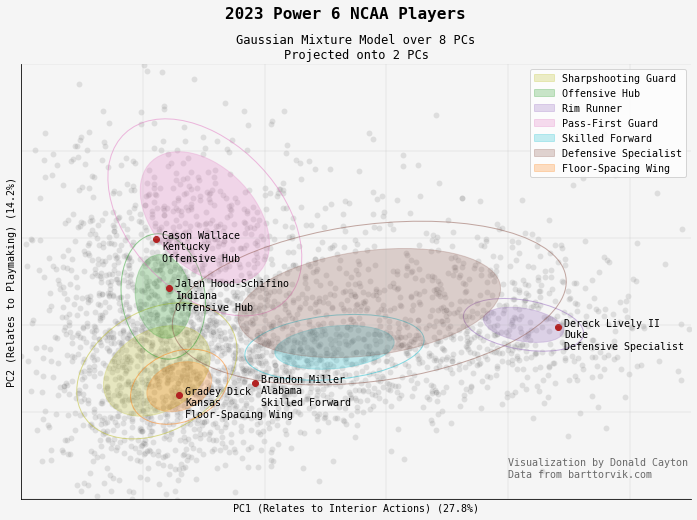

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

from scipy import linalg
import seaborn as sns

# players from power 5 schools in 2022-23
ncaa_2023 = ncaa_2[(ncaa_2["ncaa_year"]==2023)]
ncaa_2023_df_cols = ["ncaa_player_name"] + ["ncaa_team"] + ncaa_c.columns.tolist()
ncaa_2023 = ncaa_2023[ncaa_2023_df_cols]

pca_23 = pca.transform(scaler.transform(ncaa_2023.iloc[:,2:-2]))
pc1_23 = pca_23[:,0]
pc2_23 = pca_23[:,1]

pc_23_df = pd.DataFrame({"PC1": pc1_23, "PC2": pc2_23, 
                         "Primary Role": ncaa_2023.GMM_Primary_Cluster,
                         "Player Name": ncaa_2023.ncaa_player_name,
                         "Player Team": ncaa_2023.ncaa_team
                        })

mpl.rcParams["font.family"]="monospace"
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor("whitesmoke")
ax.set_facecolor("whitesmoke")

ax.grid(linewidth=.2, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelleft=False, left=False, 
               labelbottom=False, bottom=False)

ax.set_xlabel(f"PC1 (Relates to Interior Actions) ({np.round(pca.explained_variance_ratio_[0]*100,1)}%)")
ax.set_ylabel(f"PC2 (Relates to Playmaking) ({np.round(pca.explained_variance_ratio_[1]*100,1)}%)")


sns.scatterplot(x="PC1", y="PC2", data=pc_23_df, color="grey", 
                alpha=.2, zorder=1)

colors = ["tab:olive", "tab:green", "tab:purple", "tab:pink", "tab:cyan", "tab:brown", "tab:orange"]
cats = ["Sharpshooting Guard", "Offensive Hub", "Rim Runner", "Pass-First Guard", "Skilled Forward", "Defensive Specialist", "Floor-Spacing Wing"]

handles = []
labels = []

for n, color in enumerate(colors):
    covariances = gaussian.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi
    ell = patches.Ellipse(
        gaussian.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
    )
    ell2 = patches.Ellipse(
        gaussian.means_[n, :2], v[0]*1.5, v[1]*1.5, angle=180 + angle, color=color,
        fill=False
    )
    
    handles += [ell]
    labels += [cats[n]]
                                 
    ell.set_clip_box(ax.bbox)
    ell2.set_clip_box(ax.bbox)
    
    ell.set_alpha(0.25)
    ell2.set_alpha(.5)
    
    ax.add_artist(ell)
    ax.add_artist(ell2)

ax.legend(handles, labels)

selected_players = pc_23_df[(pc_23_df["Player Name"].isin(["Brandon Miller", "Gradey Dick", 
                                                         "Dereck Lively II", "Cason Wallace",
                                                         "Jalen Hood-Schifino"])) & (pc_23_df["Player Team"].isin(["Alabama", "Kansas", "Duke", "Kentucky", "Indiana"]))]
for i, row in selected_players.iterrows():
    ax.scatter(row["PC1"], row["PC2"], color="firebrick")
    ax.annotate(f"{row[3]}\n{row[4]}\n{row[2]}", xy=(row["PC1"], row["PC2"]),
                xytext=(row["PC1"]+.1, row["PC2"]-.5), size=10)
ax.set_xlim(-4, 7)
ax.set_ylim(-4, 6)
ax.text(4, -3.5, "Visualization by Donald Cayton\nData from barttorvik.com", c="dimgrey")
fig.suptitle("2023 Power 6 NCAA Players", fontweight="bold", fontsize=16)
plt.title("Gaussian Mixture Model over 8 PCs\nProjected onto 2 PCs", fontsize=12);

In [28]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

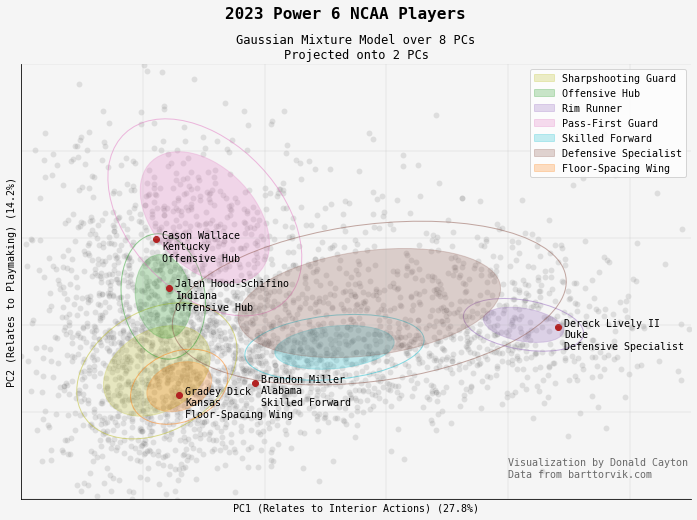

In [29]:
fig

In [30]:
viz_path = parent + "/model_visualizations/gmm_2pcs_ncaa_cluster"
fig.savefig(viz_path, bbox_inches="tight", dpi=300)

In [41]:
ncaa_2

,ncaa_player_name,ncaa_team,ncaa_conf,ncaa_gp,ncaa_minutes_%,ncaa_ortg,ncaa_usg,ncaa_efg%,ncaa_ts%,ncaa_oreb%,ncaa_dreb%,ncaa_ast%,ncaa_to%,ncaa_ftm,ncaa_fta,ncaa_ft%,ncaa_2pm,ncaa_2pa,ncaa_2p%,ncaa_3pm,ncaa_3pa,ncaa_3p%,ncaa_blk%,ncaa_stl%,ncaa_ftr,ncaa_yr,ncaa_ht,ncaa_porpag,ncaa_adjoe,ncaa_foul_rate,ncaa_year,ncaa_recruit_rank,ncaa_ast_tov_ratio,ncaa_rim_makes,ncaa_rim_att,ncaa_mid_range_makes,ncaa_mid_range_att,ncaa_rim_fg%,ncaa_mid_fg%,ncaa_dunks_made,ncaa_dunks_att,ncaa_dunk_fg%,ncaa_draft_pick,ncaa_drtg,ncaa_adrtg,ncaa_dporpag,ncaa_stops,ncaa_bpm,ncaa_obpm,ncaa_dbpm,ncaa_gbpm,ncaa_min_per_game,ncaa_ogbpm,ncaa_dgbpm,ncaa_oreb,ncaa_dreb,ncaa_treb,ncaa_ast,ncaa_stl,ncaa_blk,ncaa_pts,ncaa_fga,ncaa_tov,ncaa_ppp,ncaa_rim_prop,ncaa_mid_prop,ncaa_3pt_prop,ncaa_ast_fg_ratio,GMM_Primary_Cluster,GMM_Secondary_Cluster
0,Pooh Williams,Utah St.,WAC,32,0.640,108.3,0.181,0.530,0.533,0.023,0.059,0.146,0.141,1.031250,1.937500,0.532,2.187500,4.187500,0.522,1.125000,3.125000,0.360,0.009,0.014,0.265,Jr,75,1.801170,104.8020,2.7,2010,0.0,1.999909,1.500000,2.343750,0.687500,1.843750,0.6400,0.3729,0.187500,0.218750,0.8571,0.0,100.8750,98.5761,2.636630,124.8270,2.282520,2.42698,-0.144461,1.062230,27.3125,0.785960,0.276271,0.4688,1.3750,1.8438,2.1875,0.5938,0.2188,8.7812,7.312500,1.0938,0.948417,0.320513,0.252137,0.427350,0.299145,Offensive Hub,None
1,Dana Smith,Longwood,ind,27,0.818,99.8,0.277,0.499,0.538,0.069,0.176,0.156,0.186,4.555556,6.925926,0.658,4.666667,9.666667,0.483,1.222222,3.370370,0.363,0.014,0.014,0.531,Sr,77,2.553470,108.2240,4.3,2010,0.0,0.773810,3.037037,4.962963,1.629630,4.703704,0.6119,0.3465,0.111111,0.148148,0.7500,0.0,106.3010,110.6310,1.801420,168.4280,-0.441037,1.10734,-1.548380,-0.118050,32.7037,1.949350,-2.067400,2.1481,4.9259,7.0741,2.4074,0.8148,0.4815,17.5556,13.037037,3.1111,0.914566,0.380682,0.360795,0.258523,0.184659,Skilled Forward,None
2,Carlos Strong,Boston University,AE,35,0.762,118.1,0.164,0.588,0.609,0.047,0.115,0.123,0.151,2.085714,3.057143,0.682,1.857143,3.885714,0.478,1.685714,3.571429,0.472,0.014,0.031,0.410,Sr,75,2.758120,111.8110,3.5,2010,3.2,1.340383,1.342857,2.228571,0.542857,1.657143,0.6026,0.3276,0.371429,0.428571,0.8667,0.0,95.9093,98.0859,3.004560,215.8570,6.077490,3.66533,2.412160,5.253060,30.6857,2.914710,2.338340,1.3429,3.2286,4.5714,1.8000,1.6571,0.4000,10.8571,7.457143,1.3429,1.070173,0.298851,0.222222,0.478927,0.241379,Offensive Hub,None
3,Eulis Stephens,Detroit,Horz,31,0.316,110.2,0.139,0.513,0.559,0.061,0.106,0.084,0.160,1.064516,1.580645,0.673,1.064516,1.741935,0.611,0.129032,0.709677,0.182,0.011,0.017,0.645,Sr,76,0.655344,99.7749,3.8,2010,0.0,1.124976,0.870968,1.290323,0.193548,0.451613,0.6750,0.4286,0.129032,0.161290,0.8000,0.0,99.3834,98.5807,1.302290,70.4798,0.667967,0.23597,0.431997,0.611289,13.5484,-0.283722,0.895011,0.6774,1.2258,1.9032,0.5806,0.3871,0.1290,3.5806,2.451613,0.5161,0.977452,0.526316,0.184211,0.289474,0.236824,Defensive Specialist,Skilled Forward
4,Brett Gifford,Albany,AE,30,0.394,79.3,0.101,0.468,0.468,0.044,0.183,0.072,0.345,0.133333,0.300000,0.444,0.966667,2.033333,0.475,0.000000,0.033333,0.000,0.054,0.014,0.145,Sr,83,-1.121340,66.4800,5.0,2010,0.0,0.620668,0.533333,0.700000,0.433333,1.333333,0.7619,0.3250,0.000000,0.000000,0.0000,0.0,101.0190,104.1200,1.304400,100.5920,-2.658680,-4.68582,2.027140,-3.827150,16.9333,-5.133030,1.305880,0.6333,2.6667,3.3000,0.6000,0.4000,0.8333,2.0667,2.066667,0.9667,0.652910,0.338710,0.645161,0.016129,0.290323,Defensive Specialist,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42409,Shaman Alston,South Carolina St.,MEAC,26,0.349,79.7,0.201,0.411,0.442,0.019,0.118,0.159,0.275,1.153846,2.115385,0.545,1.653846,3.846154,0.430,0.076923,0.461538,0.167,0.013,0.022,0.491,Jr,76,-0.462273,78.9437,2.9,2023

/Users/donaldcayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


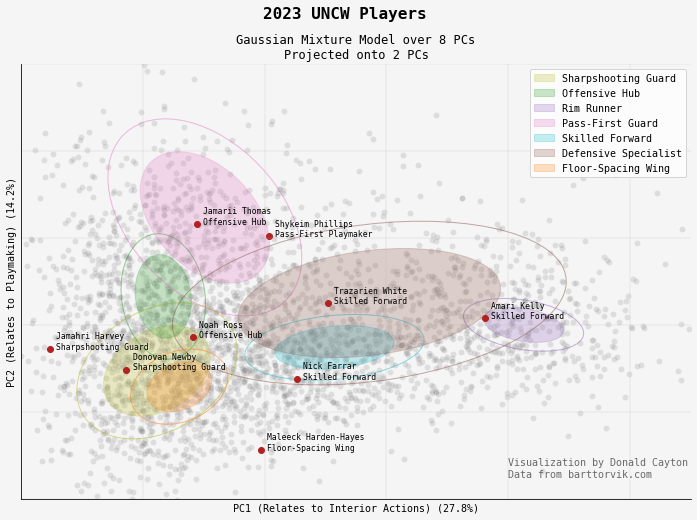

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

from scipy import linalg
import seaborn as sns

# players from NCAA schools in 2022-23
ncaa_2023 = ncaa_2[(ncaa_2["ncaa_year"]==2023) & (ncaa_2["ncaa_minutes_%"]>.2)]
ncaa_2023_df_cols = ["ncaa_player_name"] + ["ncaa_team"] + ncaa_c.columns.tolist()
ncaa_2023 = ncaa_2023[ncaa_2023_df_cols]

pca_23 = pca.transform(scaler.transform(ncaa_2023.iloc[:,2:-2]))
pc1_23 = pca_23[:,0]
pc2_23 = pca_23[:,1]

pc_23_df = pd.DataFrame({"PC1": pc1_23, "PC2": pc2_23, 
                         "Primary Role": ncaa_2023.GMM_Primary_Cluster,
                         "Secondary Role": ncaa_2023.GMM_Secondary_Cluster,
                         "Player Name": ncaa_2023.ncaa_player_name,
                         "Player Team": ncaa_2023.ncaa_team
                        })

mpl.rcParams["font.family"]="monospace"
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor("whitesmoke")
ax.set_facecolor("whitesmoke")

ax.grid(linewidth=.2, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelleft=False, left=False, 
               labelbottom=False, bottom=False)

ax.set_xlabel(f"PC1 (Relates to Interior Actions) ({np.round(pca.explained_variance_ratio_[0]*100,1)}%)")
ax.set_ylabel(f"PC2 (Relates to Playmaking) ({np.round(pca.explained_variance_ratio_[1]*100,1)}%)")


sns.scatterplot(x="PC1", y="PC2", data=pc_23_df, color="grey", 
                alpha=.2, zorder=1)

colors = ["tab:olive", "tab:green", "tab:purple", "tab:pink", "tab:cyan", "tab:brown", "tab:orange"]
cats = ["Sharpshooting Guard", "Offensive Hub", "Rim Runner", "Pass-First Guard", "Skilled Forward", "Defensive Specialist", "Floor-Spacing Wing"]

handles = []
labels = []

for n, color in enumerate(colors):
    covariances = gaussian.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi
    ell = patches.Ellipse(
        gaussian.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
    )
    ell2 = patches.Ellipse(
        gaussian.means_[n, :2], v[0]*1.5, v[1]*1.5, angle=180 + angle, color=color,
        fill=False
    )
    
    handles += [ell]
    labels += [cats[n]]
                                 
    ell.set_clip_box(ax.bbox)
    ell2.set_clip_box(ax.bbox)
    
    ell.set_alpha(0.25)
    ell2.set_alpha(.5)
    
    ax.add_artist(ell)
    ax.add_artist(ell2)

ax.legend(handles, labels)

selected_players = pc_23_df[(pc_23_df["Player Team"]=="UNC Wilmington")]

for i, row in selected_players.iterrows():
    ax.scatter(row["PC1"], row["PC2"], color="firebrick")
    ax.annotate(f"{row[4]}\n{row[2]}", xy=(row["PC1"], row["PC2"]),
                xytext=(row["PC1"]+.1, row["PC2"]), size=8)
ax.set_xlim(-4, 7)
ax.set_ylim(-4, 6)
ax.text(4, -3.5, "Visualization by Donald Cayton\nData from barttorvik.com", c="dimgrey")
fig.suptitle("2023 UNCW Players", fontweight="bold", fontsize=16)
plt.title("Gaussian Mixture Model over 8 PCs\nProjected onto 2 PCs", fontsize=12);

In [53]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [54]:
viz_path = parent + "/model_visualizations/uncw_cluster"
fig.savefig(viz_path, bbox_inches="tight", dpi=300)